In [1]:
from typing import List
from random import randint
import heapq
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
class UnionFind:
    """
       * Links to the parent node in the union find.  parents[i] is
       * set to i if i is a representative element.
    """
    #   // +--------------+------------------------------------------------
    #   // | Constructors |
    #   // +--------------+
    def __init__(self, n: int) -> None:
        self.parents = [0] * n
        self.size = [0] * n
        for i in range(n):
            self.parents[i] = i
            self.size[i] = 1
            
    #   // +---------+-----------------------------------------------------
    #   // | Methods |
    #   // +---------+

    #   /**
    #    * Given a node, find the representative node.
    #    */
    def find(self, node: int) -> int:
        """
            Given a node, find the representative node.
        Parameters
        ---------------------------------------------------------------------------
            node: int -> The node given 
        Returns
        ---------------------------------------------------------------------------
            int -> return the representative node
        """
        while self.parents[node] != node:
            node = self.parents[node]
        return node

    #   /**
    #    * Given two nodes, union their sets
    #    */
    def union(self, rep1: int, rep2: int) -> None:
        # Find the representative nodes
        rep1 = self.find(rep1)
        rep2 = self.find(rep2)
        # Determine the size of the rep1 set and the rep2 set
        if self.size[rep1] > self.size[rep2]:
            smaller = rep2
            larger = rep1
        else:
            smaller = rep1
            larger = rep2
        # Make the larger one the parent of the smaller one
        self.parents[smaller] = larger
        self.size[larger] += self.size[smaller]

In [3]:
class Edge:
    """
        Implementation of an undirected edge
    """
    #   // +--------------+------------------------------------------------
    #   // | Constructors |
    #   // +--------------+
    def __init__(self, source: int, target: int, weight: int) -> None:
        self.source = source
        self.target = target
        self.weight = weight
        
    #   // +------------------+--------------------------------------------
    #   // | Standard Methods |
    #   // +------------------+
    def __str__(self) -> str:
        return f"<{self.source} - {self.target}> : {self.weight}"
    def __lt__(self, other):
        return self.weight < other.weight

class Node:
    """
        Implementation of a node
    """
    #   // +--------------+------------------------------------------------
    #   // | Constructors |
    #   // +--------------+
    def __init__(self, key: int) -> None:
        self.key = key
        self.adj = {}
    #   // +------------------+--------------------------------------------
    #   // | Standard Methods |
    #   // +------------------+
    def __str__(self) -> str:
        return f"Node [{self.key}] with neighbors {[(adj, str(edge)) for adj, edge in self.adj.items()]}"
    def add_edge(self, edge: Edge) -> None:
        """
            Add an edge to the adjacency list of the node
        Parameters
        ---------------------------------------------------------------------------
            edge: Edge -> The edge we want to add into the adjacency list
        Returns
        ---------------------------------------------------------------------------
            None -> Return nothing
        """
        if self.key == edge.source:
            self.adj[edge.target] = edge
        if self.key == edge.target:
            self.adj[edge.source] = edge

class Graph:
    """
        Implementation of an undirected graph and hopefully it is connected 
    """
    #   // +--------------+------------------------------------------------
    #   // | Constructors |
    #   // +--------------+
    def __init__(self, edgeList = None, nodeList = None) -> None:
        self.nodeList = {}
        self.edgeList = []
        if nodeList:
            for node in nodeList:
                self.add_node(node)
        if edgeList:
            for edge in edgeList:
                self.add_edge(edge)
    @staticmethod
    def random_graph(nodeSize: int):
        """
            Generate a randomly generated graph with nodeSize nodes
        Parameters
        ---------------------------------------------------------------------------
            nodeSize: int -> the total number of node in the generated graph
        Returns
        ---------------------------------------------------------------------------
            Graph -> a randomly generated graph 
        """
        # number of edges inserted into graph, each node is connected to half of other nodes
        edgeSize = nodeSize*(nodeSize - 1) // 2.2
        maxWeight = 9223372036854775807/nodeSize/2 # a large weight distributed to the base edges
        nornalWeight = 100 # weight for non base edges
        nodeList = range(nodeSize)
        baseEdge = list(zip(range(0, nodeSize-1), range(1, nodeSize), [maxWeight] * (nodeSize-1)))
        baseEdge = [Edge(*edge) for edge in baseEdge]
        graph = Graph(edgeList = baseEdge)
        edgeInserted = nodeSize-1
        while edgeInserted < edgeSize:
            source = randint(0, nodeSize-1)
            target = randint(0, nodeSize-1)
            weight = randint(1, nornalWeight)
            if source == target:
                continue
            if graph.add_edge(Edge(source, target, weight)):
                edgeInserted += 1
        return graph
    #   // +------------------+--------------------------------------------
    #   // | Standard Methods |
    #   // +------------------+
    def __str__(self) -> str:
        self.edgeList.sort(key = lambda edge : edge.source)
        fNodes = f"Graph with \n\t Nodes: {sorted([key for key in self.nodeList.keys()])}"
        fEdges = f"\n\t Edges: {[str(edge) for edge in self.edgeList]}"
        fWeight = f"\n\t Total Weight: {self.calculate_weight()}"
        return fNodes + fEdges + fWeight
    def add_node(self, nodeKey: int) -> None:
        """
            add a new node into the graph
        Parameters
        ---------------------------------------------------------------------------
            nodeKey: int -> the key of the node inserted into the graph
        Returns
        ---------------------------------------------------------------------------
            None
        """
        self.nodeList[nodeKey] = Node(nodeKey)
    def add_edge(self, edge: Edge) -> bool:
        """
            add a new edge into the graph
        Parameters
        ---------------------------------------------------------------------------
            edge: Edge -> the edge you want to add into the graph
        Returns
        ---------------------------------------------------------------------------
            bool -> return True if no existing edges
                    return False if the edge is already in the graph
        """
        sourceKey, targetKey = edge.source, edge.target
        if sourceKey in self.nodeList.keys() and \
                targetKey in self.nodeList.keys():
            if targetKey in self.nodeList[sourceKey].adj or \
                    sourceKey in self.nodeList[targetKey].adj:
                return False
        self.edgeList.append(edge)
        if sourceKey not in self.nodeList.keys():
            ## this edge introduce a new node into graph
            self.add_node(sourceKey)
        if targetKey not in self.nodeList.keys():
            ## this edge introduce a new node into graph
            self.add_node(targetKey) 
        self.nodeList[sourceKey].add_edge(edge)
        self.nodeList[targetKey].add_edge(edge)
        return True
    def hasCycle(self) -> bool:
        """
            Check if the graph has cycles by the number of edges and nodes
            <This function is currently not working for some unknown reason :(>
        Parameters
        ---------------------------------------------------------------------------
            None
        Returns
        ---------------------------------------------------------------------------
            bool -> returns True if contains a cycle, else returns False
        """
        if len(self.edgeList) >= len(self.nodeList.keys()):
            return True
        else: # We dont need to consider unconnected graphs. 
            return False
    def calculate_weight(self) -> int:
        """
            Calculate the total weight of edges in the graph
        Parameters
        ---------------------------------------------------------------------------
            None
        Returns
        ---------------------------------------------------------------------------
            int -> returns the total weight of the graph
        """
        weightTotal = 0
        for edge in self.edgeList:
            weightTotal += edge.weight
        return weightTotal

In [4]:
# /**
#  * Algorithms over MSTs.
#  */
class MSTAlgorithm:
    """
        The abstract interface for all minimum spanning tree algorithm
    """
    def mst():
        pass
    
class Kruskals(MSTAlgorithm):
    def mst(self, graph: Graph) -> Graph:
        """
            Find the minimum spanning tree of an undirected graph using Krskals algorithm
        Parameters
        ---------------------------------------------------------------------------
            graph: Graph -> the graph we want to find MST
        Returns
        ---------------------------------------------------------------------------
            Graph -> a MST
        """
        #  Sort the edges by weight from least to greatest
        edgeList = graph.edgeList
        edgeList.sort(key = lambda edge : edge.weight)
        # Prepare a list of nodes for the MST
        mstEdge = []
        # Find the number of the largest node
        n = 0
        for edge in edgeList:
            n = max(n, edge.source, edge.target)
        # Create an appropriate UnionFind
        uf = UnionFind(n+1)
        # Go through all the edges
        for edge in edgeList:
            if uf.find(edge.source) != uf.find(edge.target):
                mstEdge.append(edge)
                uf.union(edge.source, edge.target)
        return Graph(edgeList = mstEdge)

class Prim(MSTAlgorithm):
    def mst(self, graph: Graph) -> Graph:
        """
            Find the minimum spanning tree of an undirected graph using Prim's algorithm
        Parameters
        ---------------------------------------------------------------------------
            graph: Graph -> the graph we want to find MST
        Returns
        ---------------------------------------------------------------------------
            Graph -> a MST
        """
        # The maximum nodekey in the graph
        nodeKeyMax = max(list(graph.nodeList.keys()))
        # The array to see if nodeKey is viewed 
        viewed = [0] * (nodeKeyMax + 1)
        # Current node to process
        currentNode = randint(0, nodeKeyMax)
        viewed[currentNode] = 1
        # priority queue for storing the edges 
        pq = []
        # list containing edges in mst
        mstEdge = []
        # UnionFind instance to check if there is a cycle
        uf = UnionFind(nodeKeyMax+1)
        for _, edge in graph.nodeList[currentNode].adj.items():
            # push all the edges for current node into pq
            heapq.heappush(pq, edge)
        while pq:
            edge = heapq.heappop(pq)
            if viewed[edge.source] and viewed[edge.target]:
                continue
            if viewed[edge.source]:
                currentNode = edge.target
            else:
                currentNode = edge.source
            if uf.find(edge.source) != uf.find(edge.target):
                mstEdge.append(edge)
                uf.union(edge.source, edge.target)
                viewed[edge.source] = 1
                viewed[edge.target] = 1
                for _, edge in graph.nodeList[currentNode].adj.items():
                    if viewed[edge.source] and viewed[edge.target]:
                        continue
                    heapq.heappush(pq, edge)
        return Graph(mstEdge)

In [5]:
# /**
#  * A quick experiment with msts.
#  */
class MSTAlgorithmTest:
    def test(self, graph: Graph, algorithm: MSTAlgorithm) -> Graph:
        # Run the algorithm on the graph
        mst = algorithm.mst(graph)
        return mst
    
test = MSTAlgorithmTest()
graph = Graph.random_graph(5)
print("MST generated from Prim's algorithm:")
print(test.test(graph, Prim()))
print("MST generated from Kruskals algorithm:")
print(test.test(graph, Kruskals()))

MST generated from Prim's algorithm:
Graph with 
	 Nodes: [0, 1, 2, 3, 4]
	 Edges: ['<0 - 2> : 56', '<3 - 0> : 12', '<3 - 1> : 44', '<4 - 0> : 67']
	 Total Weight: 179
MST generated from Kruskals algorithm:
Graph with 
	 Nodes: [0, 1, 2, 3, 4]
	 Edges: ['<0 - 2> : 56', '<3 - 0> : 12', '<3 - 1> : 44', '<4 - 0> : 67']
	 Total Weight: 179


In [6]:
class MSTAlgorithmTimer:
    @staticmethod
    def timer(algorithm: MSTAlgorithm, graph: Graph) -> int:
        """
            Calculate time it takes for the give algorithm to run on the graph provided
        Parameters
        ---------------------------------------------------------------------------
            algorithm: MSTAlgorithm -> The mst algorithm we are using 
            graph: Graph -> The graph that we run MST algorithm on 
        Returns
        ---------------------------------------------------------------------------
            int -> the time it takes to run the algorithm in 1e-4 second 
        """
        start = time.time()
        algorithm.mst(graph)
        end = time.time()
        return int((end - start) * 1e4)
    @staticmethod
    def complexity(iteration: int, sizes: List[int], algorithm: MSTAlgorithm) -> pd.DataFrame:
        """
            Calculate the time complexity for the algorithm and store data into a pd.DataFrame
        Parameters
        ---------------------------------------------------------------------------
            iteration: int -> the number of iterations we run
            sizes: List[int] -> the list containing the sizes of nodes for 
                the graph we are randomly generating 
            algorithm: MSTAlgorithm -> mst algorithm we are experimenting with 
        Returns
        ---------------------------------------------------------------------------
            pd.DataFrame -> a table summarizing the time complexity for different 
                iterations and sizes we used
        """
        current = 0
        box = []
        while current < iteration:
            row = []
            for size in sizes:
                graph = Graph.random_graph(size)
                timer = MSTAlgorithmTimer()
                row.append(MSTAlgorithmTimer.timer(algorithm, graph))
                # print(f'Iteraction {current}, size {size}')
            box.append(row)
            current += 1
        return pd.DataFrame(data = box, columns = sizes)

In [7]:
iteractions = 50
sizes = list(range(20, 200, 5))

kruskalsDF = MSTAlgorithmTimer.complexity(iteractions, sizes, Kruskals())
PrimDF = MSTAlgorithmTimer.complexity(iteractions, sizes, Prim())

In [8]:
kruskalsDF.to_csv('kruskalsDF.csv')
PrimDF.to_csv('PrimDF.csv')

In [9]:
kruskalsDF_stacked = pd.DataFrame(kruskalsDF.stack())
size = [i[1] for i in np.array(kruskalsDF_stacked.index)]
time = [i[0] for i in kruskalsDF_stacked.values]
kruskalsDF_stacked = pd.DataFrame({'Size' : size,
             'Time' : time})
kruskalsDF_stacked['algorithm'] = 'kruskals'
kruskalsDF_stacked = kruskalsDF_stacked.sort_values('Size')
PrimDF_stacked = pd.DataFrame(kruskalsDF.stack())
size = [i[1] for i in np.array(PrimDF_stacked.index)]
time = [i[0] for i in PrimDF_stacked.values]
PrimDF_stacked = pd.DataFrame({'Size' : size,
             'Time' : time})
PrimDF_stacked['algorithm'] = 'Prim'
PrimDF_stacked = PrimDF_stacked.sort_values('Size')
comparisonDF = pd.merge(kruskalsDF_stacked, PrimDF_stacked, how = 'outer')

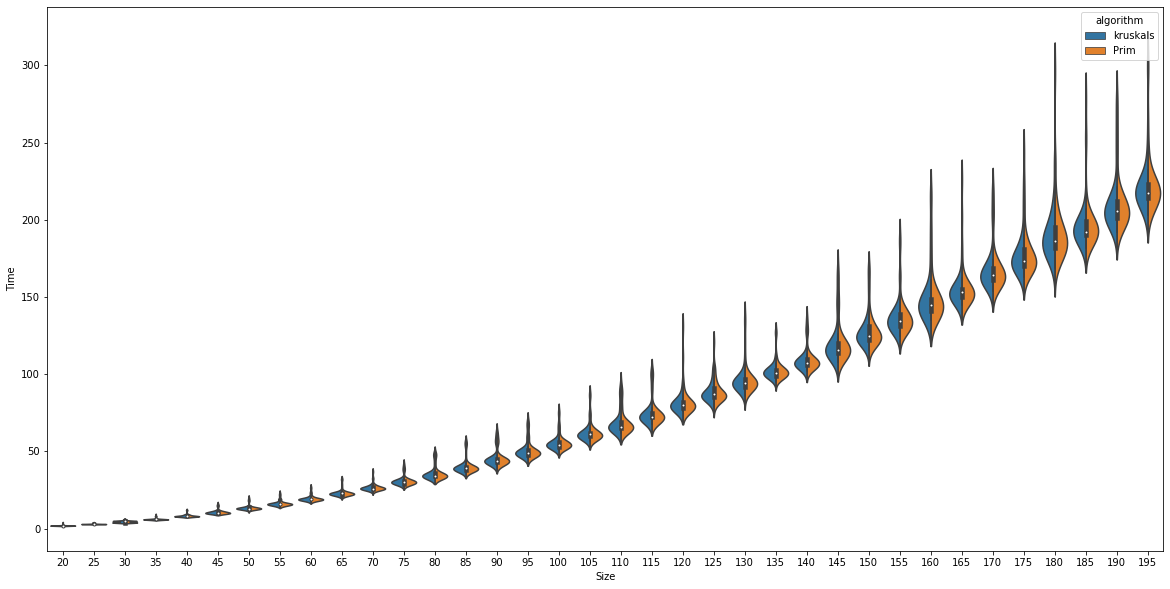

In [10]:
plt.figure(figsize = [20, 10])
sns.violinplot(x = 'Size', y = 'Time', hue = 'algorithm',
               data = comparisonDF, split = True)